In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import lumiere as lm
lm.loadstyle(True)

Using KIT colors.
Custom style set.


## Stick-Slip-Model


> Stick–slip can be modeled as a mass coupled by an elastic spring to a constant drive force (see the model sketch). The drive system V applies a constant force, loading spring R and increasing the pushing force against load M. This force increases until retarding force from the static friction coefficient between load and floor is exceeded. The load then starts sliding, and the friction coefficient decreases to the value corresponding to load times the dynamic friction. Since this frictional force will be lower than the static value, the load accelerates until the decompressing spring can no longer generate enough force to overcome dynamic friction, and the load stops moving. The pushing force due to the spring builds up again, and the cycle repeats. 
> 
> \- [wikipedia](https://en.wikipedia.org/wiki/Stick%E2%80%93slip_phenomenon)

 Also have a look at: [Ref](https://www.stle.org/images/pdf/STLE_ORG/BOK/LS/Friction/Slip-Stick_What%27s%20it%20all%20about_tlt%20article_June11.pdf)

---


 ![Image](https://upload.wikimedia.org/wikipedia/commons/d/d0/Stick-slip.svg)
  
[Image](https://upload.wikimedia.org/wikipedia/commons/d/d0/Stick-slip.svg)  by [Jean-Jacques MILAN](https://commons.wikimedia.org/wiki/User:Jean-Jacques_MILAN) under [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/)


1. Slipping condition:
When the spring force exceeds the maximum static friction force (|F_hook| > F_max), the mass slips. In this case, the equation of motion is:

$$ m\frac{d^2x}{dt^2} = F_{\text{Hook}} + F_{\text{fric}} = -k\cdot x + \mu_k \cdot mg $$

2. Sticking condition:
When the spring force is less than or equal to the maximum static friction force (|F_hook| ≤ F_max), the mass sticks to the surface and moves with the external velocity. In this case:

$$ \frac{dx}{dt} = v_\text{ext} \quad \frac{d^2x}{dt^2} = 0 $$

We can combine these conditions into a single equation using the Heaviside step function H(x):

$$
m\frac{d^2x}{dt^2} = 
\begin{cases}
     -k\cdot x + \mu_k \cdot mg &\quad |F_{\text{Hook}}| > F_{\text{max}} \\
     0 &\quad |F_{\text{Hook}}| < F_{\text{max}} \\
\end{cases}
$$

- $x$:     displacement
- $t$:     time
- $m$:     the mass
- $k$:     spring constant
- $g$:     gravitational acceleration
- $\mu_k$:   coefficient of kinetic friction
- $\mu_s$:   coefficient of static friction
- $v_{\text{ext}}$: external velocity

In [2]:
class System:
    def __init__(self, v=0, v_external=2., dt=0.01, m=1., g=10, k=2., dx=0.,mu_static=1., mu_kinetic= 0.4):
        self.v = v                  # Initial velocity of the mass (m/s)
        self.v_external = v_external  # External velocity (m/s)
        self.dt = dt                # Time step (s)
        self.m = m                  # Mass (kg)
        self.g = g                  # Gravitational acceleration (m/s^2)
        self.k = k                  # Spring constant (kg/s^2)
        self.dx = dx                # Displacement (m)
        self.mu_static = mu_static  # Coefficient of static friction (1)
        self.mu_kinetic = mu_kinetic # Coefficient of kinetic friction (1)
        
        self.t = 0                  # Time (s)

        # History storage
        self.positions = []
        self.velocities = []
        self.acceleration = []



    def step(self):
        
        self.t += self.dt
        
        # Forces on system
        F_hook = -self.k * self.dx
        F_n = self.m * self.g
        F_max = self.mu_static * F_n

        # Slipping
        if abs(F_hook) > F_max:

            # Kinetic friction
            F_kinetic = self.mu_kinetic * F_n
            
            F_tot = F_hook + F_kinetic
            a = F_tot / self.m
            self.v += a * self.dt
            self.dx += self.v * self.dt

        # Sticking
        else:
            a = 0
            self.v = self.v_external
            self.dx += self.v * self.dt

        # Store values
        self.positions.append(self.dx)
        self.velocities.append(self.v)
        self.acceleration.append(a)


    def run(self, n_steps, show=True):
        time = self.t + np.arange(n_steps)*self.dt

        for i in range(n_steps):
            self.step()

        if show:
            fig, axs = plt.subplots(3,1, figsize=(12,12))
            params = [(self.positions[-n_steps:]   , r'$x\;[m]$'    , r'position'      , 'C0', 0),
                    (self.velocities[-n_steps:]  , r'$v\;[m/s]$'  , r'velocity'      , 'C1', 1),
                    (self.acceleration[-n_steps:], r'$a\;[m/s^2]$', r'acceleration'  , 'C2', 2)]
            for (f, label, title, color, idx) in params:
                axs[idx].plot(time , f, color=color)
                #axs[idx].set_title(title)
                axs[idx].set_ylabel(label)
            axs[0].set_xticklabels([])
            axs[1].set_xticklabels([])
            axs[-1].set_xlabel('t [s]')
            plt.show()


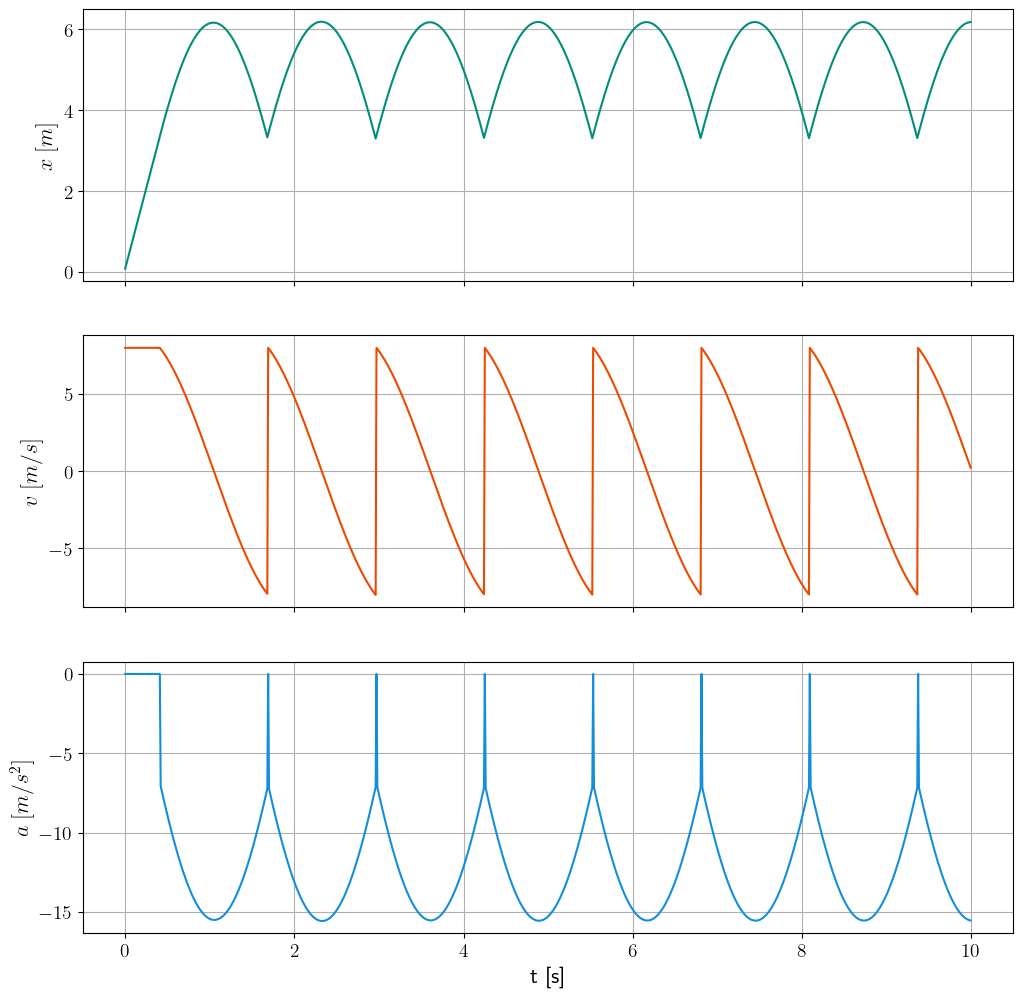

In [3]:
s = System(v_external=8., dt=0.01, m=1., g=10, k=3., dx=0., mu_static=1., mu_kinetic= 0.3)
s.run(1000)

## FFT

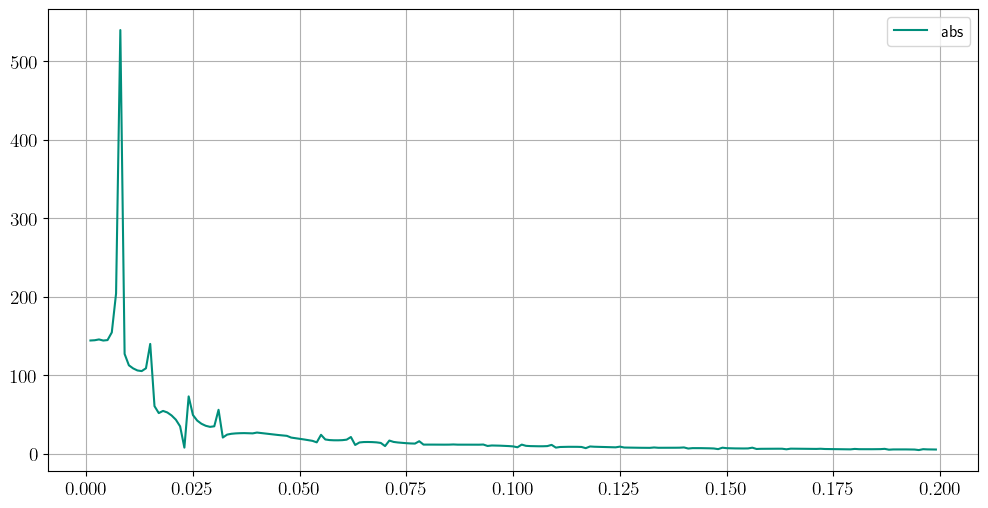

In [4]:
from scipy import fft

N = len(s.positions)
yf = fft.fft(s.positions)[1:N//5]
xf = fft.fftfreq(N)[1:N//5]

#plt.plot(xf, yf.real, label='real')
#plt.plot(xf, yf.imag, label='imag')
plt.plot(xf, np.abs(yf), label='abs')

plt.legend()
plt.show()

#### Just for fun

In [5]:
from scipy.io.wavfile import write

nn = 10_0000
s.k = 3.
s.run(nn, show=False)
output = s.positions[-nn:]
output /= np.max(output)


sample_rate = 44100 
audio_data = np.int16(output * 32767)
write("output.wav", sample_rate, audio_data)